In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC


### Load data

In [151]:
df = pd.read_csv('train-3.csv')
df_test = pd.read_csv('test-4.csv')
df.head()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,...,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,ITCHY_NOSE,ITCHY_EYES,ITCHY_MOUTH,ITCHY_INNER_EAR,SNEEZING,PINK_EYE,TYPE
0,1,0,1,1,0,1,0,0,0,0,...,0,1,1,1,1,1,0,1,1,ALLERGY
1,1,1,0,0,1,0,0,0,1,1,...,1,1,1,0,0,0,0,1,0,FLU
2,1,1,0,0,1,1,0,0,0,0,...,0,1,1,0,0,0,1,0,1,ALLERGY
3,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,FLU
4,1,0,1,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,1,0,FLU


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40007 entries, 0 to 40006
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 40007 non-null  int64 
 1   MUSCLE_ACHES          40007 non-null  int64 
 2   TIREDNESS             40007 non-null  int64 
 3   SORE_THROAT           40007 non-null  int64 
 4   RUNNY_NOSE            40007 non-null  int64 
 5   STUFFY_NOSE           40007 non-null  int64 
 6   FEVER                 40007 non-null  int64 
 7   NAUSEA                40007 non-null  int64 
 8   VOMITING              40007 non-null  int64 
 9   DIARRHEA              40007 non-null  int64 
 10  SHORTNESS_OF_BREATH   40007 non-null  int64 
 11  DIFFICULTY_BREATHING  40007 non-null  int64 
 12  LOSS_OF_TASTE         40007 non-null  int64 
 13  LOSS_OF_SMELL         40007 non-null  int64 
 14  ITCHY_NOSE            40007 non-null  int64 
 15  ITCHY_EYES            40007 non-null

In [153]:
df['TYPE'].value_counts()

TYPE
FLU        22499
ALLERGY    14729
COVID       1849
COLD         930
Name: count, dtype: int64

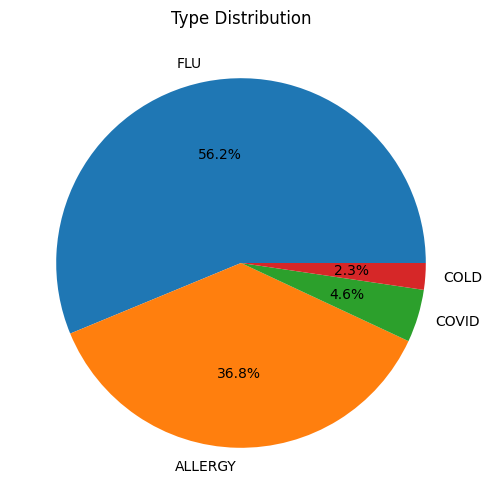

In [154]:
df['TYPE'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6))
plt.title('Type Distribution')
plt.ylabel('')
plt.show()

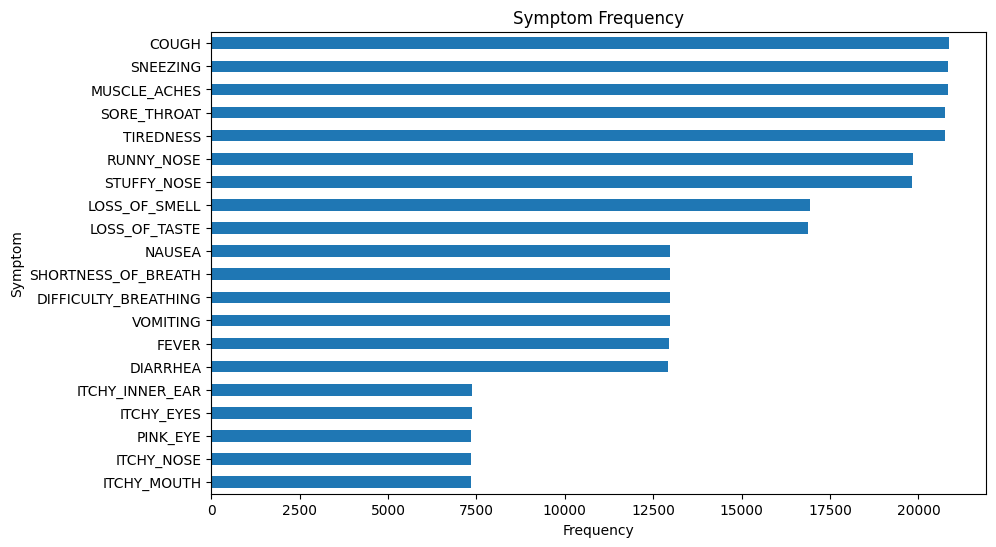

In [155]:
symptom_cols = [col for col in df.columns if col != 'TYPE']
symptom_sums = df[symptom_cols].sum()

symptom_sums.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Symptom Frequency')
plt.xlabel('Frequency')
plt.ylabel('Symptom')
plt.show()

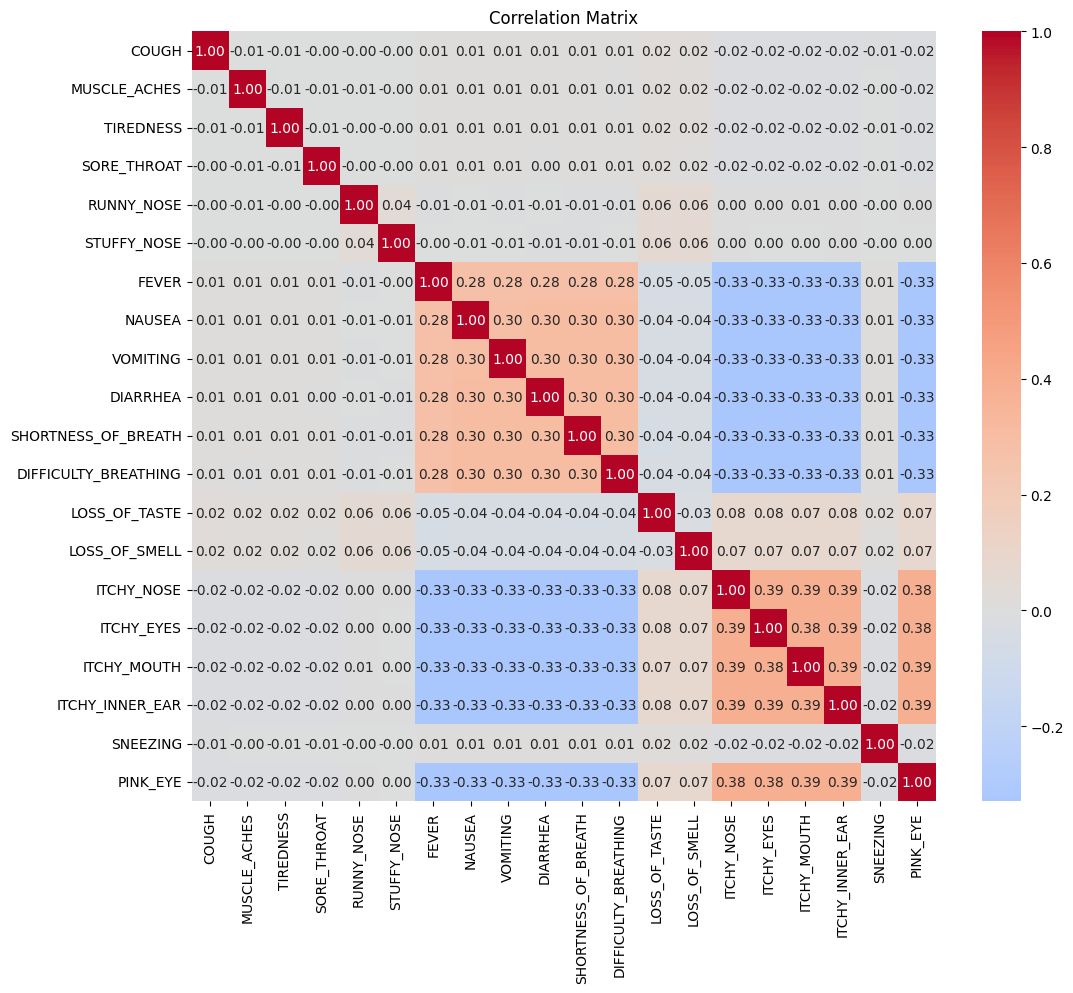

In [156]:
without_type_df = df.drop('TYPE', axis=1)
correlation_matrix = without_type_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')

plt.show()

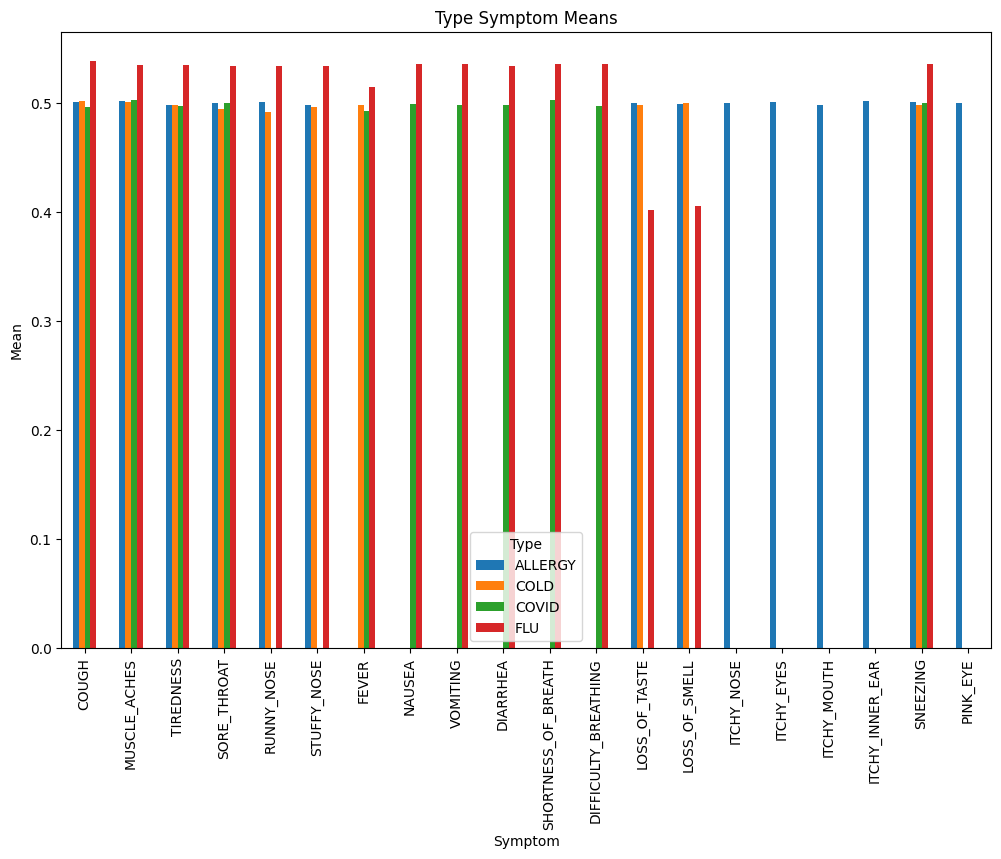

In [157]:
type_symptom_means = df.groupby('TYPE').mean()
type_symptom_means.T.plot(kind='bar', figsize=(12, 8))
plt.title('Type Symptom Means')
plt.xlabel('Symptom')
plt.ylabel('Mean')
plt.legend(title='Type')

plt.show()

## Classification
### Data preprocessing

In [158]:
le = LabelEncoder()
df['TYPE'] = le.fit_transform(df['TYPE'])
df_test['TYPE'] = le.transform(df_test['TYPE'])

X = df.drop('TYPE', axis=1)  # Features
y = df['TYPE']  # Target variable

### Handle imbalanced data

In [159]:
rus = RandomUnderSampler(random_state=42, sampling_strategy={0: 7000, 3: 7000})
X_resampled, y_resampled = rus.fit_resample(X, y)
print("Original dataset sample distribution:", Counter(y))
print("Balanced dataset sample distribution:", Counter(y_resampled))

Original dataset sample distribution: Counter({3: 22499, 0: 14729, 2: 1849, 1: 930})
Balanced dataset sample distribution: Counter({0: 7000, 3: 7000, 2: 1849, 1: 930})


### Split data

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

### Model training

In [161]:
# Logistic Regression
param_grid = {
    'estimator__C': [0.1, 0.5, 1, 5, 10],  # Regularization strength
    'estimator__penalty': ['l1', 'l2'],    # Type of regularization
    'estimator__solver': ['liblinear', 'saga']  # Solver
}

# Initialize Logistic Regression model
lr = LogisticRegression(
    max_iter=1000,         # Maximum iterations for convergence
    random_state=42,       # For reproducibility
    class_weight='balanced' # Handle class imbalance
)

# Wrap Logistic Regression with OneVsRestClassifier
ovr = OneVsRestClassifier(lr)

# Perform grid search
grid_search_lr = GridSearchCV(ovr, param_grid, cv=5, return_train_score=True)
grid_search_lr.fit(X_train, y_train)
print("Best Parameters:", grid_search_lr.best_params_)

Best Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


In [162]:
lr_model = LogisticRegression(
    C=10,                 # Optimized regularization strength (from grid search)
    max_iter=1000,         # Maximum iterations for convergence
    random_state=42,       # For reproducibility
    class_weight='balanced', # Handle class imbalance
    penalty='l2',           # L2 regularization (Ridge)
    solver='liblinear',
)

In [163]:
#SVM
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' and 'poly'
}
svm_model = SVC(kernel='linear', random_state=42)
grid_search_svm = GridSearchCV(svm_model, param_grid, cv=5, return_train_score=True)
grid_search_svm.fit(X_train, y_train)
print("Best Parameters:", grid_search_svm.best_params_)


Best Parameters: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}


In [164]:
svm_model = SVC(
    C=0.5,
    kernel='linear',
    gamma='scale',
    random_state=42
)

### Cross validation

In [165]:
cv_scores_lr = cross_val_score(lr_model, X_train, y_train, cv=5)
cv_scores_svm = cross_val_score(svm_model, X_train, y_train, cv=5)
print("Logistic Regression Cross Validation Scores:", cv_scores_lr)
print("SVM Cross Validation Scores:", cv_scores_svm)

Logistic Regression Cross Validation Scores: [0.94562384 0.94599628 0.94711359 0.95007452 0.94783905]
SVM Cross Validation Scores: [0.94636872 0.94636872 0.94748603 0.94895678 0.94783905]


### Fit models

In [166]:
lr_model.fit(X_train, y_train);
svm_model.fit(X_train, y_train);

### Predictions

In [167]:
y_pred_lr = lr_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test)

### Evaluation

In [168]:
print("Logistic Regression Validation Metrics:")
print("Accuracy:", lr_model.score(X_test, y_test))
print(classification_report(y_test, y_pred_lr))

print("SVM Validation Metrics:")
print("Accuracy:", svm_model.score(X_test, y_test))
print(classification_report(y_test, y_pred_svm))

Logistic Regression Validation Metrics:
Accuracy: 0.9407032181168057
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1400
           1       0.71      0.98      0.83       186
           2       0.74      0.96      0.84       370
           3       1.00      0.90      0.95      1400

    accuracy                           0.94      3356
   macro avg       0.86      0.95      0.90      3356
weighted avg       0.96      0.94      0.94      3356

SVM Validation Metrics:
Accuracy: 0.9410011918951132
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1400
           1       0.71      1.00      0.83       186
           2       0.75      0.96      0.84       370
           3       1.00      0.90      0.95      1400

    accuracy                           0.94      3356
   macro avg       0.86      0.96      0.90      3356
weighted avg       0.96      0.94      0.94      3356



In [169]:
df_test_scaled_X = pd.DataFrame(
    df_test.drop('TYPE', axis=1),
    columns=df_test.drop('TYPE', axis=1).columns
)
y_pred_lr_test = lr_model.predict(df_test_scaled_X)
y_pred_svm_test = svm_model.predict(df_test_scaled_X)


print("Logistic Regression Test Metrics:")
print("Accuracy:", lr_model.score(df_test_scaled_X, df_test['TYPE']))
print(classification_report(df_test['TYPE'], y_pred_lr_test))

print("SVM Test Metrics:")
print("Accuracy:", svm_model.score(df_test_scaled_X, df_test['TYPE']))
print(classification_report(df_test['TYPE'], y_pred_svm_test))


Logistic Regression Test Metrics:
Accuracy: 0.9260008996851102
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1652
           1       0.47      0.99      0.63        94
           2       0.47      0.97      0.63       199
           3       1.00      0.89      0.94      2501

    accuracy                           0.93      4446
   macro avg       0.73      0.96      0.80      4446
weighted avg       0.96      0.93      0.94      4446

SVM Test Metrics:
Accuracy: 0.9260008996851102
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1652
           1       0.45      1.00      0.62        94
           2       0.48      0.97      0.64       199
           3       1.00      0.89      0.94      2501

    accuracy                           0.93      4446
   macro avg       0.73      0.96      0.80      4446
weighted avg       0.96      0.93      0.94      4446



## Clustering
### Data preprocessing

In [170]:
# Combine training and test data
full_df = pd.concat([df, df_test], axis=0)
print("Combined dataset shape:", full_df.shape)

X = full_df.drop('TYPE', axis=1)
y = full_df['TYPE']

Combined dataset shape: (44453, 21)


### Clustering with K-Means


In [171]:
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans_labels = kmeans.fit_predict(X)

### Clustering with Gaussian Mixture Model

In [172]:
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X)

### Evaluation


In [173]:
print("K-means Silhouette Score:", silhouette_score(X, kmeans_labels))
print("K-means Adjusted Rand Score:", adjusted_rand_score(y, kmeans_labels))
print("Gaussian Mixture Model Silhouette Score:", silhouette_score(X, gmm_labels))
print("Gaussian Mixture Model Adjusted Rand Score:", adjusted_rand_score(y, gmm_labels))

K-means Silhouette Score: 0.04924108575214405
K-means Adjusted Rand Score: 0.432168070883109
Gaussian Mixture Model Silhouette Score: 0.030628060837553973
Gaussian Mixture Model Adjusted Rand Score: 0.581682778697438


### Visualization

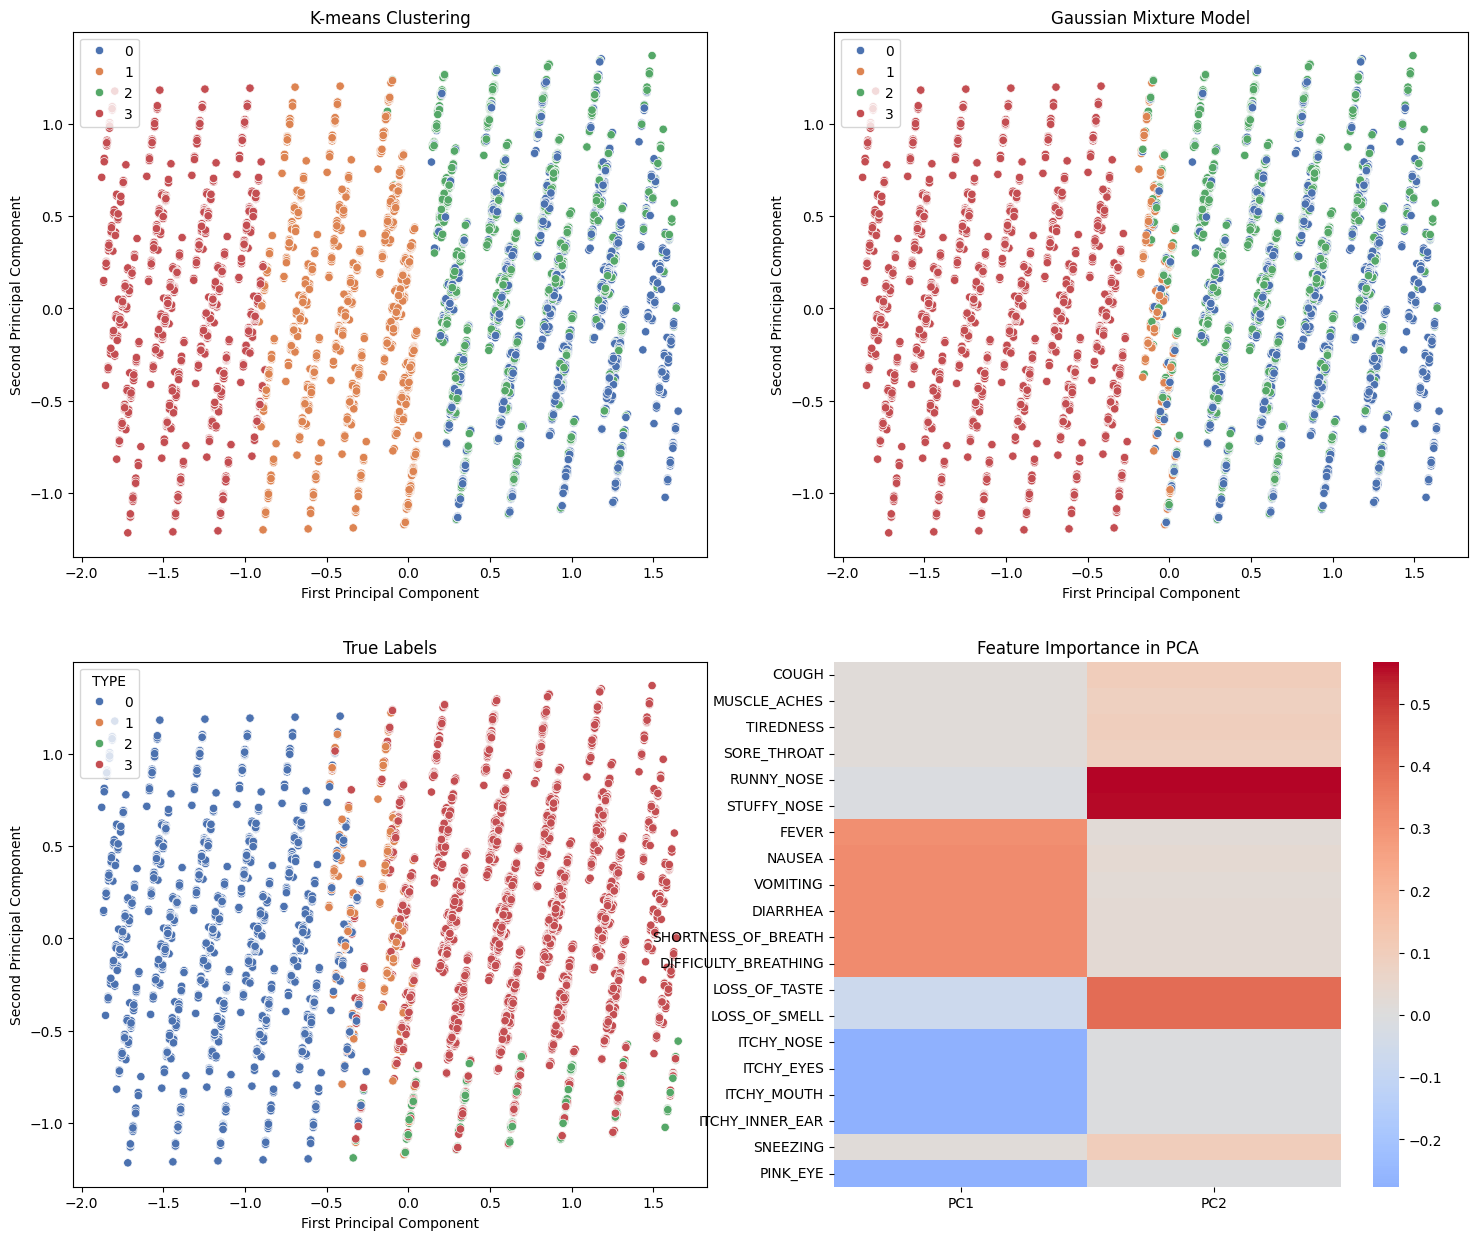

In [174]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plotting
plt.figure(figsize=(18, 15))

# Plot 1: K-means clustering
plt.subplot(2, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='deep')
plt.title('K-means Clustering')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot 2: Gaussian Mixture Model
plt.subplot(2, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='deep')
plt.title('Gaussian Mixture Model')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot 3: True labels
plt.subplot(2, 2, 3)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='deep')
plt.title('True Labels')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Plot 4: Feature importance in PCA
plt.subplot(2, 2, 4)
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns
)
sns.heatmap(feature_importance, cmap='coolwarm', center=0)
plt.title('Feature Importance in PCA')

plt.show()